In [250]:
import fiona
import pandas as pd
import geopandas as gpd
import os

In [186]:
os.chdir('/Users/dannyha/SoCalEVCSNetwork')
os.getcwd()

'/Users/dannyha/SoCalEVCSNetwork'

# Data Importing and Cleaning

## SoCal Zipcodes and Geometry

In [216]:
socal_zipcodes = pd.read_csv (r'data/socal_zipcodes/socal_zip.csv')

In [217]:
socal_zipcodes = socal_zipcodes[['ZCTA5CE10','GEOID10','INTPTLAT10','INTPTLON10','geometry']]

In [218]:
socal_zipcodes = socal_zipcodes.rename(columns={"ZCTA5CE10": "Zip Code", "GEOID10": "GEOID", "INTPTLAT10": "Latitude",
                              "INTPTLON10": "Longitude", "geometry": "Geometry"})

In [219]:
socal_zipcodes.head()

,Zip Code,GEOID,Latitude,Longitude,Geometry
0,91504,691504,34.204568,-118.326365,"POLYGON ((-118.348583 34.208461, -118.348564 3..."
1,91606,691606,34.185767,-118.388324,"POLYGON ((-118.403066 34.19394, -118.402564 34..."
2,90640,690640,34.015444,-118.111012,"POLYGON ((-118.128344 33.985893, -118.127359 3..."
3,91770,691770,34.065493,-118.084529,"POLYGON ((-118.107291 34.066222, -118.107323 3..."
4,90290,690290,34.107728,-118.615981,"POLYGON ((-118.640641 34.125821, -118.640133 3..."


In [220]:
socal_zipcodes['Zip Code'] = socal_zipcodes['Zip Code'].apply(str)

In [221]:
socal_zipcodes_shp = gpd.read_file(r'data/socal_zipcodes/socal_zip.shp')

In [222]:
socal_zipcodes_shp.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands.  British Virgin Island

In [223]:
socal_zipcodes_shp

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry
0,06,91504,0691504,B5,G6350,S,12783282,29685,+34.2045683,-118.3263651,N,"POLYGON ((-118.34858 34.20846, -118.34856 34.2..."
1,06,91606,0691606,B5,G6350,S,8631179,25464,+34.1857670,-118.3883235,N,"POLYGON ((-118.40307 34.19394, -118.40256 34.1..."
2,06,90640,0690640,B5,G6350,S,21990769,104151,+34.0154437,-118.1110124,N,"POLYGON ((-118.12834 33.98589, -118.12736 33.9..."
3,06,91770,0691770,B5,G6350,S,16634980,138149,+34.0654930,-118.0845292,N,"POLYGON ((-118.10729 34.06622, -118.10732 34.0..."
4,06,90290,0690290,B5,G6350,S,51935407,24096,+34.1077280,-118.6159812,N,"POLYGON ((-118.64064 34.12582, -118.64013 34.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...
350,06,92694,0692694,B5,G6350,S,24593751,0,+33.5472357,-117.6237601,N,"POLYGON ((-117.65254 33.56291, -117.65168 33.5..."
351,06,92831,0692831,B5,G6350,S,15476120,0,+33.8797675,-117.8963405,N,"POLYGON ((-117.91359 33.86940, -117.91359 33.8..."
352,06,92707,0692707,B5,G6350,S,13022655,17402,+33.7099350,-117.8704307,N,"MULTIPOLYGON (((-117.87814 33.66436, -117.8780..."
353,06,92648,0692648,B5,G6350,S,20791068,5188261,+33.6790097,-118.0146032,N,"MULTIPOLYGON (((-118.01199 33.69955, -118.0120..."


In [224]:
socal_zipcodes_shp['Zip Code'] = socal_zipcodes_shp['ZCTA5CE10']

## DMV Data

In [225]:
vehicles = pd.read_csv (r'data/vehicle-count-as-of-1-1-2020.csv',header=1)

/Users/dannyha/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [226]:
#filtering by socal zipcodes
socal_vehicles = vehicles[vehicles['Zip Code'].isin(socal_zipcodes['Zip Code'])]

In [227]:
#filtering light duty vehicles
socal_vehicles = socal_vehicles[socal_vehicles['Duty']=='Light']

In [228]:
socal_vehicles.head()

,Date,Zip Code,Model Year,Fuel,Make,Duty,Vehicles
0,1/1/2020,90001,2007,Gasoline,ACURA,Light,15
1,1/1/2020,90002,2007,Gasoline,ACURA,Light,20
2,1/1/2020,90003,2007,Gasoline,ACURA,Light,29
3,1/1/2020,90004,2007,Gasoline,ACURA,Light,19
4,1/1/2020,90006,2007,Gasoline,ACURA,Light,15


In [229]:
#filtering EVs and Light-duty vehicles
socal_evs = socal_vehicles[socal_vehicles['Fuel'].isin(['Battery Electric','Plug-in Hybrid'])]
socal_evs = socal_evs.reset_index()
socal_evs = socal_evs[['Zip Code','Model Year','Fuel','Make','Duty','Vehicles']]

In [230]:
socal_vehicles['Vehicles'] = socal_vehicles['Vehicles'].astype(int)

In [231]:
socal_evs_agg = socal_evs[['Zip Code','Vehicles']].groupby('Zip Code').sum('Vehicles')
socal_evs_agg

,Vehicles
Zip Code,
90001,134.0
90002,162.0
90003,136.0
90004,1294.0
90005,560.0
...,...
93543,60.0
93550,NaN
93551,1074.0


In [232]:
socal_evs_agg['Electric Vehicles'] = socal_evs_agg['Vehicles']
socal_evs_agg = socal_evs_agg.drop(columns='Vehicles') 
socal_evs_agg.head()

,Electric Vehicles
Zip Code,
90001,134.0
90002,162.0
90003,136.0
90004,1294.0
90005,560.0


In [233]:
socal_vehicles_by_zip = socal_vehicles[['Zip Code','Vehicles']].groupby('Zip Code').sum('Vehicles')
socal_vehicles_by_zip

,Vehicles
Zip Code,
90001,67498
90002,61550
90003,82098
90004,66370
90005,34626
...,...
93543,21824
93550,105820
93551,86680


In [234]:
ev_percentage = socal_vehicles_by_zip.merge(socal_evs_agg, how='inner', on='Zip Code')
ev_percentage.columns=['Total Vehicles','Electric Vehicles']
ev_percentage.head()

,Total Vehicles,Electric Vehicles
Zip Code,,
90001,67498,134.0
90002,61550,162.0
90003,82098,136.0
90004,66370,1294.0
90005,34626,560.0


In [235]:
ev_percentage['EV Percentage'] = ev_percentage['Electric Vehicles'] / ev_percentage['Total Vehicles']
ev_percentage = ev_percentage[['Electric Vehicles','Total Vehicles','EV Percentage']]
ev_percentage.head()

,Electric Vehicles,Total Vehicles,EV Percentage
Zip Code,,,
90001,134.0,67498,0.001985
90002,162.0,61550,0.002632
90003,136.0,82098,0.001657
90004,1294.0,66370,0.019497
90005,560.0,34626,0.016173


In [236]:
merged_ev_percentage = ev_percentage.merge(socal_zipcodes_shp, how='right', on='Zip Code')
merged_ev_percentage

,Zip Code,Electric Vehicles,Total Vehicles,EV Percentage,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry
0,91504,894.0,41206.0,0.021696,06,91504,0691504,B5,G6350,S,12783282,29685,+34.2045683,-118.3263651,N,"POLYGON ((-118.34858 34.20846, -118.34856 34.2..."
1,91606,736.0,60668.0,0.012132,06,91606,0691606,B5,G6350,S,8631179,25464,+34.1857670,-118.3883235,N,"POLYGON ((-118.40307 34.19394, -118.40256 34.1..."
2,90640,842.0,89968.0,0.009359,06,90640,0690640,B5,G6350,S,21990769,104151,+34.0154437,-118.1110124,N,"POLYGON ((-118.12834 33.98589, -118.12736 33.9..."
3,91770,1484.0,96060.0,0.015449,06,91770,0691770,B5,G6350,S,16634980,138149,+34.0654930,-118.0845292,N,"POLYGON ((-118.10729 34.06622, -118.10732 34.0..."
4,90290,710.0,11048.0,0.064265,06,90290,0690290,B5,G6350,S,51935407,24096,+34.1077280,-118.6159812,N,"POLYGON ((-118.64064 34.12582, -118.64013 34.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,92694,3014.0,47900.0,0.062923,06,92694,0692694,B5,G6350,S,24593751,0,+33.5472357,-117.6237601,N,"POLYGON ((-117.65254 33.56291, -117.65168 33.5..."
351,92831,1138.0,48246.0,0.023587,06,92831,0692831,B5,G6350,S,15476120,0,+33.8797675,-117.8963405,N,"POLYGON ((-117.91359 33.86940, -117.91359 33.8..."
352,92707,612.0,86204.0,0.007099,06,92707,0692707,B5,G6350,S,13022655,17402,+33.7099350,-117.8704307,N,"MULTIPOLYGON (((-117.87814 33.66436, -117.8780..."
353,92648,2830.0,78906.0,0.035865,06,92648,0692648,B5,G6350,S,20791068,5188261,+33.6790097,-118.0146032,N,"MULTIPOLYGON (((-118.01199 33.69955, -118.0120..."


In [259]:
gdf_merged_ev_percentage = GeoDataFrame(merged_ev_percentage, crs="EPSG:3857", 
                                        geometry=merged_ev_percentage['geometry'])

In [260]:
gdf_merged_ev_percentage

,Zip Code,Electric Vehicles,Total Vehicles,EV Percentage,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry
0,91504,894.0,41206.0,0.021696,06,91504,0691504,B5,G6350,S,12783282,29685,+34.2045683,-118.3263651,N,"POLYGON ((-118.34858 34.20846, -118.34856 34.2..."
1,91606,736.0,60668.0,0.012132,06,91606,0691606,B5,G6350,S,8631179,25464,+34.1857670,-118.3883235,N,"POLYGON ((-118.40307 34.19394, -118.40256 34.1..."
2,90640,842.0,89968.0,0.009359,06,90640,0690640,B5,G6350,S,21990769,104151,+34.0154437,-118.1110124,N,"POLYGON ((-118.12834 33.98589, -118.12736 33.9..."
3,91770,1484.0,96060.0,0.015449,06,91770,0691770,B5,G6350,S,16634980,138149,+34.0654930,-118.0845292,N,"POLYGON ((-118.10729 34.06622, -118.10732 34.0..."
4,90290,710.0,11048.0,0.064265,06,90290,0690290,B5,G6350,S,51935407,24096,+34.1077280,-118.6159812,N,"POLYGON ((-118.64064 34.12582, -118.64013 34.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,92694,3014.0,47900.0,0.062923,06,92694,0692694,B5,G6350,S,24593751,0,+33.5472357,-117.6237601,N,"POLYGON ((-117.65254 33.56291, -117.65168 33.5..."
351,92831,1138.0,48246.0,0.023587,06,92831,0692831,B5,G6350,S,15476120,0,+33.8797675,-117.8963405,N,"POLYGON ((-117.91359 33.86940, -117.91359 33.8..."
352,92707,612.0,86204.0,0.007099,06,92707,0692707,B5,G6350,S,13022655,17402,+33.7099350,-117.8704307,N,"MULTIPOLYGON (((-117.87814 33.66436, -117.8780..."
353,92648,2830.0,78906.0,0.035865,06,92648,0692648,B5,G6350,S,20791068,5188261,+33.6790097,-118.0146032,N,"MULTIPOLYGON (((-118.01199 33.69955, -118.0120..."


<AxesSubplot:>

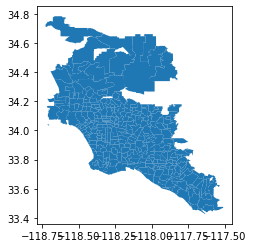

In [261]:
gdf_merged_ev_percentage.plot()

In [159]:
#merged_ev_percentage.to_csv(r'merged_ev_percentage.csv')

## Cluster Analysis

In [262]:
clusters = gpd.read_file(r'data/chargers_socal_acs_kmeans.geojson')

In [265]:
clusters =  clusters.to_crs(epsg=3857)

In [266]:
clusters.columns

Index(['Connections_0_LevelID', 'Connections_0_PowerKW',
       'Connections_0_Quantity', 'betweenness_centrality',
       'closeness_centrality', 'degree_centrality', 'median_age',
       'median_hh_income', 'total_pop', 'hh_total', 'avg_travel_time',
       'pct_white', 'pct_black', 'pct_asian', 'pct_hispanic', 'pct_bachelor',
       'pct_access_to_veh', 'pct_30-34_min', 'pct_45-49_min', 'k', 'geometry'],
      dtype='object')

In [267]:
clusters_filtered = clusters[['k', 'geometry', 'median_age',
       'median_hh_income', 'total_pop', 'hh_total', 'avg_travel_time',
       'pct_white', 'pct_black', 'pct_asian', 'pct_hispanic', 'pct_bachelor',
       'pct_access_to_veh', 'pct_30-34_min', 'pct_45-49_min']]

In [268]:
clusters_filtered.head()

,k,geometry,median_age,median_hh_income,total_pop,hh_total,avg_travel_time,pct_white,pct_black,pct_asian,pct_hispanic,pct_bachelor,pct_access_to_veh,pct_30-34_min,pct_45-49_min
0,4,POINT (inf inf),38.2,82479.0,7403.0,7403.0,37.507692,71.444009,0.742942,5.916520,79.022018,3.620154,39.511009,8.955829,6.038093
1,4,POINT (inf inf),34.0,79353.0,4677.0,4677.0,36.647500,61.364122,4.639726,5.687406,72.567885,1.325636,42.762455,8.210391,5.986744
2,4,POINT (inf inf),38.5,68388.0,4141.0,4141.0,41.035928,65.563873,3.018595,8.741850,72.856798,0.941801,40.328423,8.452065,4.998793
3,4,POINT (inf inf),38.2,82479.0,7403.0,7403.0,37.507692,71.444009,0.742942,5.916520,79.022018,3.620154,39.511009,8.955829,6.038093
4,4,POINT (inf inf),38.5,68388.0,4141.0,4141.0,41.035928,65.563873,3.018595,8.741850,72.856798,0.941801,40.328423,8.452065,4.998793


<AxesSubplot:>

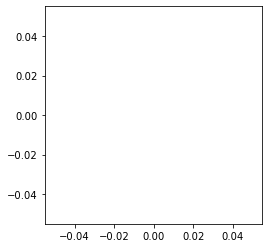

In [269]:
clusters_filtered.plot()

<AxesSubplot:>

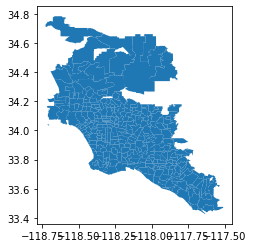

In [270]:
gdf_merged_ev_percentage.plot()

In [271]:
#ev population share
chargers_and_ev_percentage = gpd.sjoin(clusters_filtered, gdf_merged_ev_percentage, op='within')

In [272]:
chargers_and_ev_percentage

,k,geometry,median_age,median_hh_income,total_pop,hh_total,avg_travel_time,pct_white,pct_black,pct_asian,...,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10
